# Capstone Project Final

Explore and cluster the neighborhoods in Toronto. You can decide to work with only boroughs that contain the word Toronto and then replicate the same analysis we did to the New York City data. It is up to you. 

Just make sure:

to add enough Markdown cells to explain what you decided to do and to report any observations you make. 
to generate maps to visualize your neighborhoods and how they cluster together. 
Once you are happy with your analysis, submit a link to the new Notebook on your Github repository.

In [1]:
#!conda install -c conda-forge geopy --yes
#!conda install -c conda-forge geocoder
#!conda install -c conda-forge folium
#!conda install -c conda-forge sklearn --yes


In [2]:
# The code was removed by Watson Studio for sharing.

In [3]:
from bs4 import BeautifulSoup
import requests
import os
import pandas as pd
import numpy as np
import time
from geopy.geocoders import Nominatim 
import geocoder
import folium 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import types
import ibm_boto3
from botocore.client import Config

app = Nominatim(user_agent="tutorial")

In [4]:
List_url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_V"
source = requests.get(List_url).text

In [5]:
soup = BeautifulSoup(source, 'xml')

In [6]:
table_contents=[]
table=soup.find('table')
for row in table.findAll('td'):
    cell = {}
    
    if row.span.text=='Not assigned':
        pass
    else:
        #print (row.prettify())
        try:
            #if 'Vancouver' in row.span.text:
            if row.span.text:
                cell['PostalCode'] = row.b.text[:3]
                cell['Borough'] = (row.span.text).split('(')[0]
                cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')

                if cell['PostalCode'] not in ['V3A','V9A','V9B','V9C','V9E','V7H','V7K','V8L','V8N','V8P','V8R','V8S','V4T','V8T','V9T','V8V','V8W','V8X','V9X','V8Y','V8Z']:
                    table_contents.append(cell)
        except:
            pass

#print(table_contents)
df_init=pd.DataFrame(table_contents)
df=pd.DataFrame()


In [7]:
df_init.shape

(48, 3)

In [8]:
def get_location_by_address(postalcode):
    """This function returns a location as raw from an address
    will repeat until success"""
    time.sleep(0.1)
    
    address = '{}, Vancouver , Ontario'.format(postalcode)
    
    try:
        location = app.geocode(address).raw
        latitude = location["lat"]
        longitude = location["lon"]
        
        return latitude,longitude
    except:
        return np.nan, np.nan


In [9]:

if os.environ.get('RUNTIME_ENV_LOCATION_TYPE') == 'external':
    endpoint_265c9e76e7814f9e96d3a6e53983c093 = 'https://s3-api.us-geo.objectstorage.softlayer.net'
else:
    endpoint_265c9e76e7814f9e96d3a6e53983c093 = 'https://s3-api.us-geo.objectstorage.service.networklayer.com'

client_265c9e76e7814f9e96d3a6e53983c093 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='0mRjM9klCr8R9UGEIkosjgg5D18_7J6L-cN207JEFMFA',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url=endpoint_265c9e76e7814f9e96d3a6e53983c093)

body = client_265c9e76e7814f9e96d3a6e53983c093.get_object(Bucket='capstoneproject-donotdelete-pr-0oo7exldq9ibha',Key='Geospatial_Coordinates_2.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

geo_df = pd.read_csv(body)
geo_df.rename(columns={'Postal Code':'PostalCode'},inplace=True)
geo_df['PostalCode'] = geo_df['PostalCode'].str.strip()
geo_df.head()


,PostalCode,Latitude,Longitude
0,V5A,49.266519,-122.936557
1,V6A,49.277722,-123.090575
2,V5B,49.271882,-122.976632
3,V6B,49.279990,-123.115413
4,V7B,49.185816,-123.172296


In [10]:

df = df_init.merge(geo_df, on='PostalCode')
df.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,V5A,Burnaby,"Government Road, Lake City, SFU, Burnaby Mountain",49.266519,-122.936557
1,V6A,Vancouver,"Strathcona, Chinatown, Downtown Eastside",49.277722,-123.090575
2,V5B,Burnaby,"Parkcrest-Aubrey, Ardingley-Sprott",49.271882,-122.976632
3,V6B,Vancouver,"NE Downtown, Gastown, Harbour Centre, Internat...",49.279990,-123.115413
4,V7B,Richmond,"Sea Island, YVR",49.185816,-123.172296


In [11]:
CLIENT_ID = 'XRV4KJ0V0TORIHM2R1FTBXMZ23421YSF4CRWXMMYOW3IOXBJ' # your Foursquare ID
CLIENT_SECRET = 'L3IHYUVKLDHUBUI1EZ5LQQGFGMGEKLWXVXTE3KTR5NNSURI1' # your Foursquare Secret
ACCESS_TOKEN = 'BMA0PNGRNIX35GTJX4TGLYAO2IMTA1TM5YYGA1LPLROPM5WH' # your FourSquare Access Token
VERSION = '20180604'

In [12]:
def getNearbyVenues(names, latitudes, longitudes):
    radius=600
    LIMIT=100
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [13]:
df_venues = getNearbyVenues(names=df['Neighborhood'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

Government Road, Lake City, SFU, Burnaby Mountain
Strathcona, Chinatown, Downtown Eastside
Parkcrest-Aubrey, Ardingley-Sprott
NE Downtown, Gastown, Harbour Centre, International Village, Victory Square, Yaletown
Sea Island, YVR
Burnaby Heights, Willingdon Heights, West Central Valley
Waterfront, Coal Harbour, Canada Place
Lakeview-Mayfield, Richmond Park, Kingsway-Beresford
SE West End, Davie Village
Cascade-Schou, Douglas-Gilpin
NW West End, Stanley Park
district municipality Outer East
Maywood, Marlborough, Oakalla, Windsor
West Fairview, Granville Island, NE Shaughnessy
Suncrest, Sussex-Nelson, Clinton-Glenwood, West Big Bend
NW Shaughnessy, East Kitsilano, Quilchena
district municipality East Central
North Hastings-Sunrise
Central Kitsilano, Greektown
North Grandview-Woodland
NW Arbutus Ridge, NE Dunbar-Southlands
city South Central
Includes Annacis Island
South Hastings-Sunrise, North Renfrew-Collingwood
South Shaughnessy, NW Oakridge, NE Kerrisdale, SE Arbutus Ridge
city Southwes

In [14]:
df_venues_group = df_venues.groupby("Neighborhood").count()
neighborhood_less10 = df_venues_group[df_venues_group["Venue"]<10].index.tolist()
df_venues = df_venues[~df_venues["Neighborhood"].isin(neighborhood_less10)].reset_index()
df_venues_group = df_venues.groupby("Neighborhood").count()
df_venues_group["Neighborhood_name"] = df_venues_group.index

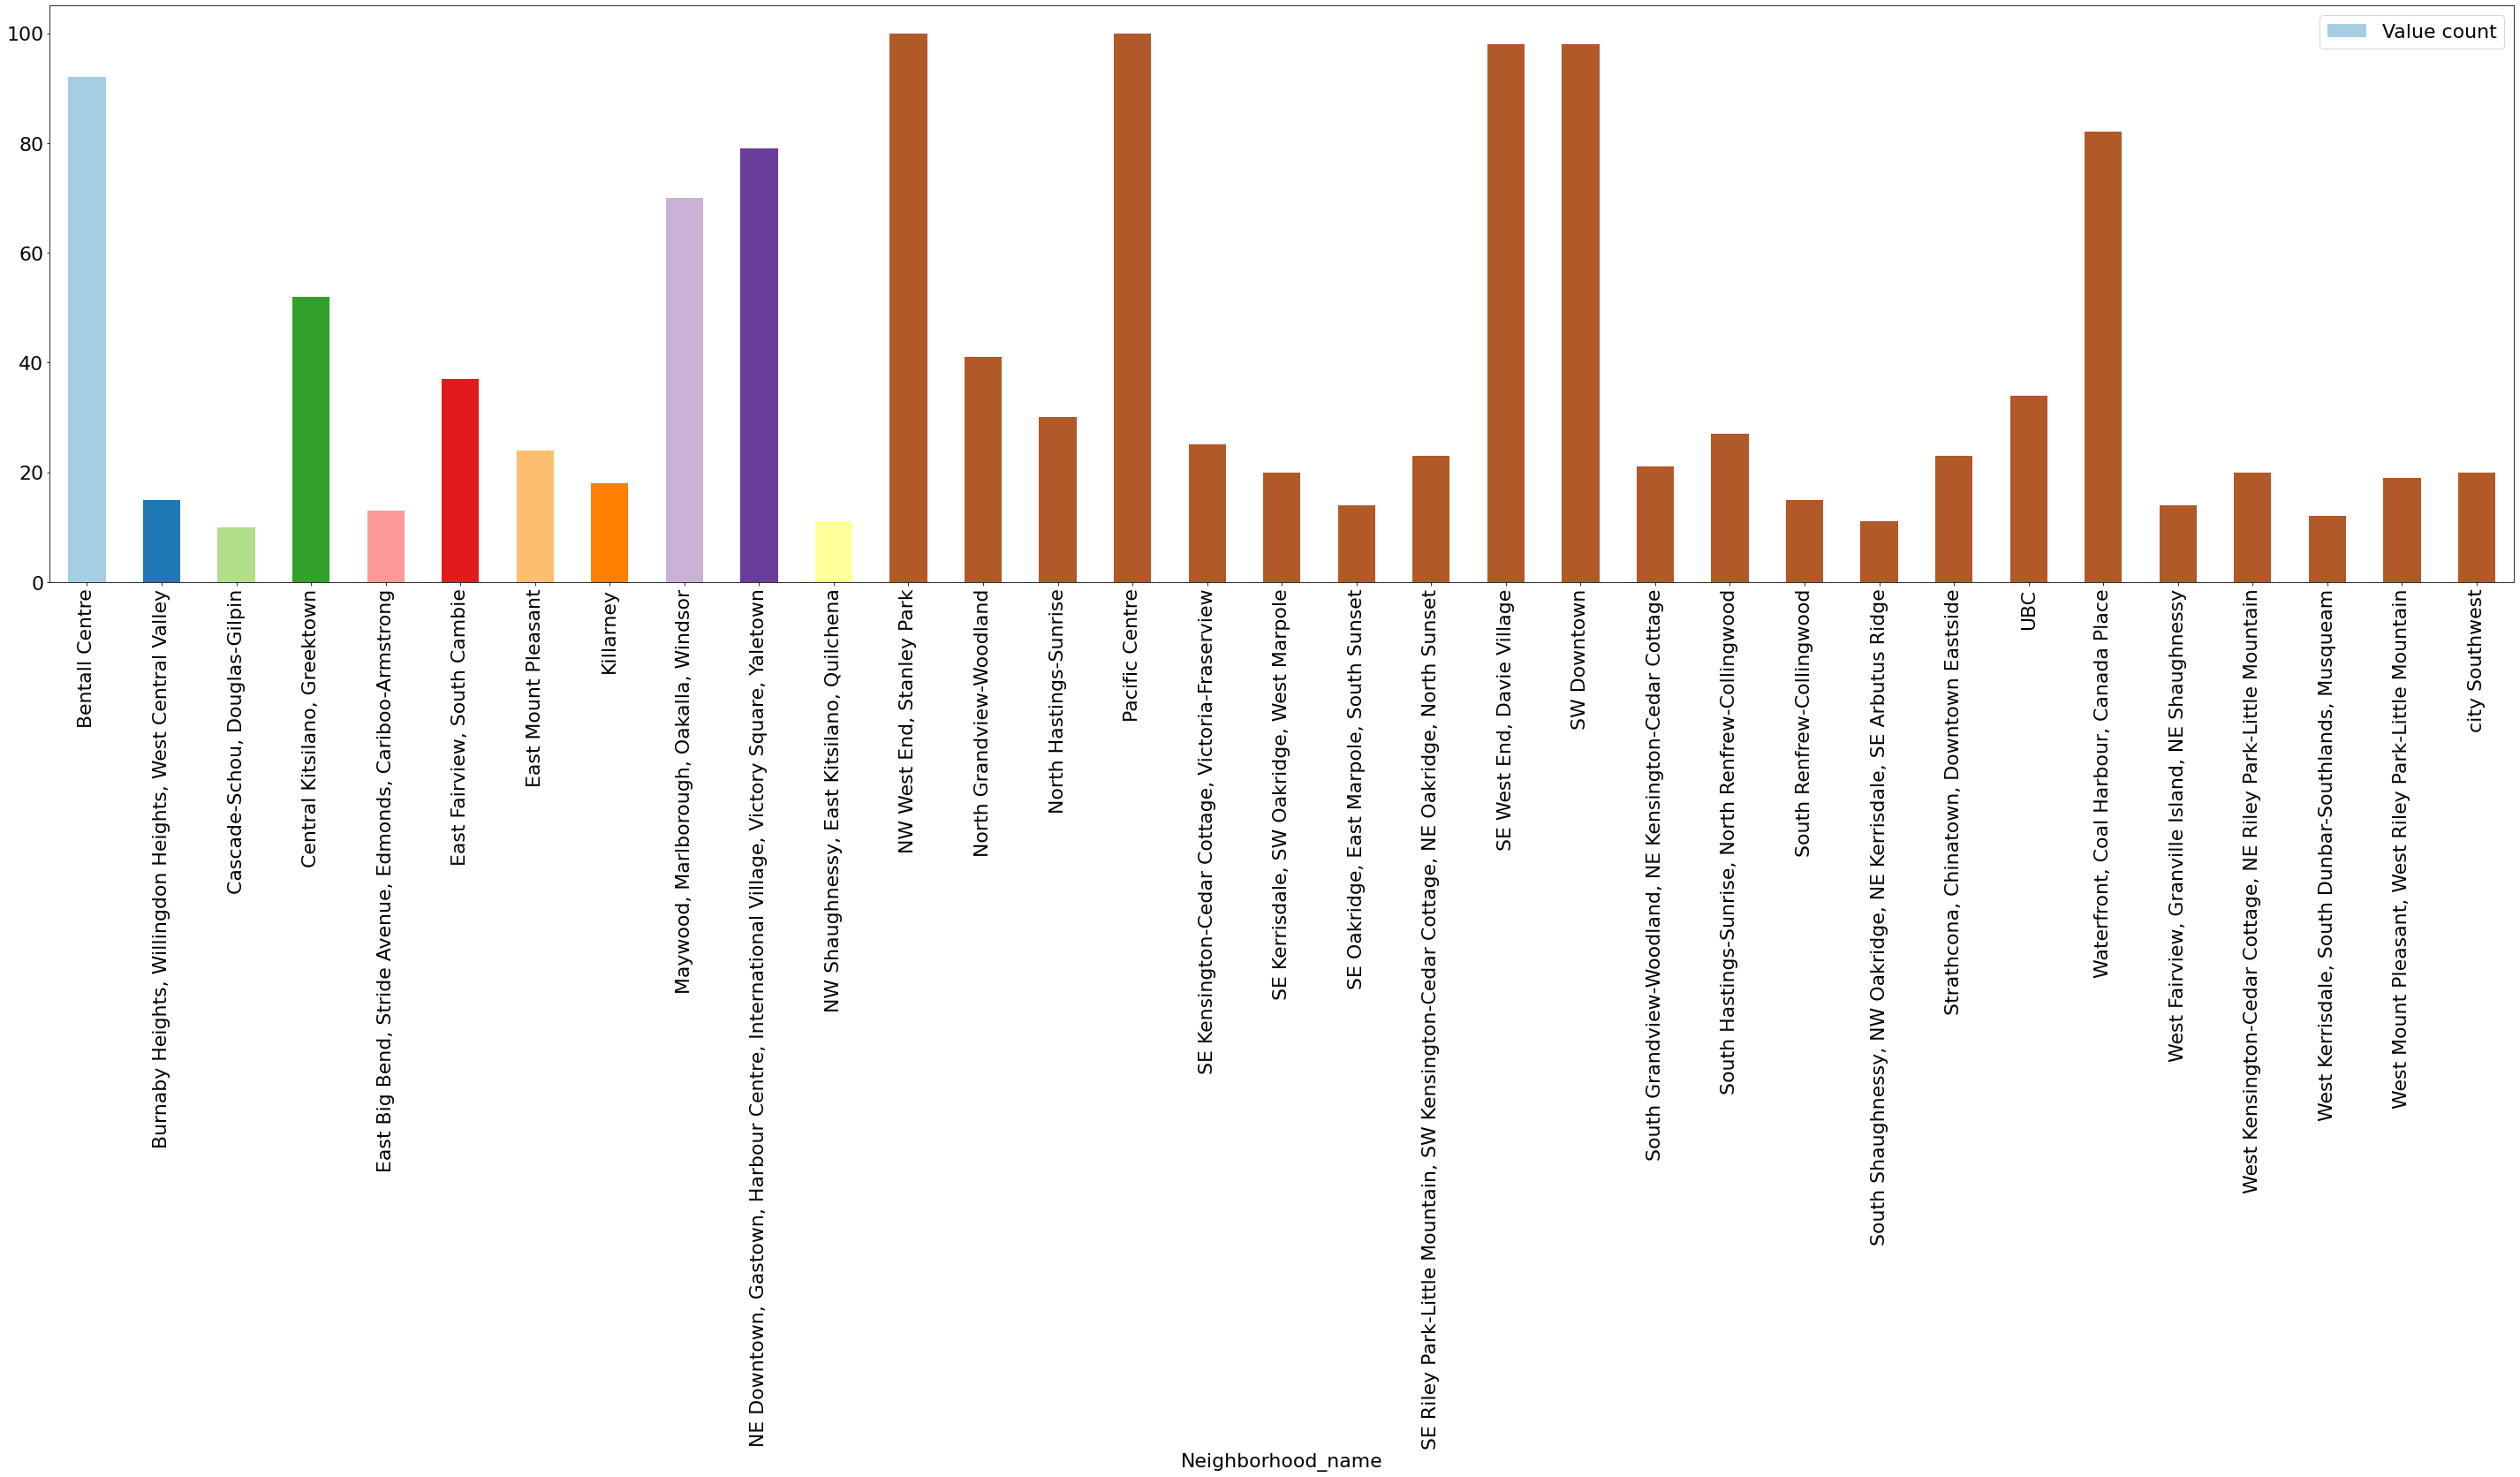

In [15]:
fig_size = plt.rcParams["figure.figsize"] #Get current size
fig_size[0] = 50                        #Set figure width to 12 and height to 9
fig_size[1] = 12
plt.rcParams["figure.figsize"] = fig_size
plt.rcParams.update({'font.size': 22})

df_venues_group.plot(x="Neighborhood_name", y='Venue', kind='bar', label='Value count', color=plt.cm.Paired(np.arange(2*len(df_venues_group))))

plt.show()

In [16]:
# one hot encoding
vancouver_onehot = pd.get_dummies(df_venues[['Venue Category']], prefix="", prefix_sep="")
vancouver_onehot.insert(loc=0, column='Neighborhood', value=df_venues['Neighborhood'] )
vancouver_onehot.head()

,Neighborhood,Accessories Store,African Restaurant,American Restaurant,Amphitheater,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,Auto Dealership,...,Thrift / Vintage Store,Toy / Game Store,Trade School,Udon Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Shop,Women's Store,Yoga Studio
0,"Strathcona, Chinatown, Downtown Eastside",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Strathcona, Chinatown, Downtown Eastside",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Strathcona, Chinatown, Downtown Eastside",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Strathcona, Chinatown, Downtown Eastside",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Strathcona, Chinatown, Downtown Eastside",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
vancouver_grouped = vancouver_onehot.groupby('Neighborhood').mean().reset_index()
vancouver_grouped.head()

,Neighborhood,Accessories Store,African Restaurant,American Restaurant,Amphitheater,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,Auto Dealership,...,Thrift / Vintage Store,Toy / Game Store,Trade School,Udon Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Shop,Women's Store,Yoga Studio
0,Bentall Centre,0.0,0.0,0.021739,0.0,0.0,0.01087,0.0,0.0,0.000000,...,0.0,0.010870,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.021739
1,"Burnaby Heights, Willingdon Heights, West Cent...",0.0,0.0,0.066667,0.0,0.0,0.00000,0.0,0.0,0.066667,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000
2,"Cascade-Schou, Douglas-Gilpin",0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000
3,"Central Kitsilano, Greektown",0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.000000,...,0.0,0.019231,0.0,0.0,0.038462,0.0,0.019231,0.0,0.019231,0.019231
4,"East Big Bend, Stride Avenue, Edmonds, Cariboo...",0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000


In [18]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

def return_most_common_venues_size(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.values[0:num_top_venues]

In [19]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = vancouver_grouped['Neighborhood']

for ind in np.arange(vancouver_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(vancouver_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bentall Centre,Hotel,Café,Dessert Shop,Food Truck,Coffee Shop,Plaza,Restaurant,Yoga Studio,Burger Joint,Cosmetics Shop
1,"Burnaby Heights, Willingdon Heights, West Cent...",Bus Station,Design Studio,Auto Dealership,Sandwich Place,Deli / Bodega,Clothing Store,Motorcycle Shop,Restaurant,Hotel,Burger Joint
2,"Cascade-Schou, Douglas-Gilpin",Chinese Restaurant,Food Court,Bus Stop,Electronics Store,Food & Drink Shop,Bookstore,Sandwich Place,Auto Garage,Snack Place,Accessories Store
3,"Central Kitsilano, Greektown",Coffee Shop,Café,Pizza Place,Bank,Pub,Japanese Restaurant,Indian Restaurant,Vegetarian / Vegan Restaurant,Chinese Restaurant,Deli / Bodega
4,"East Big Bend, Stride Avenue, Edmonds, Cariboo...",Restaurant,Chinese Restaurant,Convenience Store,Bar,Gas Station,Sandwich Place,Burger Joint,Pet Store,Eastern European Restaurant,Italian Restaurant


In [21]:
vancouver_grouped_tot = vancouver_onehot.groupby('Neighborhood').sum().reset_index()

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
        
# create a new dataframe
neighborhoods_venues_sorted_tot = pd.DataFrame(columns=columns)

neighborhoods_venues_sorted_tot['Neighborhood'] = vancouver_grouped_tot['Neighborhood']

for ind in np.arange(vancouver_grouped_tot.shape[0]):
    neighborhoods_venues_sorted_tot.iloc[ind, 1:] = return_most_common_venues_size(vancouver_grouped_tot.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted_tot.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bentall Centre,10,6,5,4,3,3,3,2,2,2
1,"Burnaby Heights, Willingdon Heights, West Cent...",2,1,1,1,1,1,1,1,1,1
2,"Cascade-Schou, Douglas-Gilpin",2,1,1,1,1,1,1,1,1,0
3,"Central Kitsilano, Greektown",7,3,3,2,2,2,2,2,2,2
4,"East Big Bend, Stride Avenue, Edmonds, Cariboo...",2,2,2,1,1,1,1,1,1,1


In [22]:
# set number of clusters
kclusters = 6

vancouver_grouped_clustering = vancouver_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=10).fit(vancouver_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([2, 2, 4, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 1, 0, 1, 2, 2, 2,
       2, 5, 0, 2, 2, 2, 2, 2, 3, 2, 2], dtype=int32)

In [23]:
# add clustering labels
if 'Cluster Labels' not in neighborhoods_venues_sorted.columns:
    neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

vancouver_merged = df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
vancouver_merged = vancouver_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

vancouver_merged = vancouver_merged.dropna()
vancouver_merged['Cluster Labels'] = vancouver_merged['Cluster Labels'].astype(int)

vancouver_merged.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,V6A,Vancouver,"Strathcona, Chinatown, Downtown Eastside",49.277722,-123.090575,2,Asian Restaurant,Japanese Restaurant,Coffee Shop,Gourmet Shop,Brewery,Soup Place,Food Truck,Chinese Restaurant,Noodle House,Seafood Restaurant
3,V6B,Vancouver,"NE Downtown, Gastown, Harbour Centre, Internat...",49.279990,-123.115413,2,Hotel,Restaurant,Café,Coffee Shop,Seafood Restaurant,Taco Place,Bakery,Sandwich Place,Bar,Spa
5,V5C,Burnaby,"Burnaby Heights, Willingdon Heights, West Cent...",49.265306,-123.020519,2,Bus Station,Design Studio,Auto Dealership,Sandwich Place,Deli / Bodega,Clothing Store,Motorcycle Shop,Restaurant,Hotel,Burger Joint
6,V6C,Vancouver,"Waterfront, Coal Harbour, Canada Place",49.287389,-123.115207,2,Hotel,Café,Boat or Ferry,Sandwich Place,Coffee Shop,Cruise Ship,American Restaurant,Food Truck,Tea Room,Donut Shop
8,V6E,Vancouver,"SE West End, Davie Village",49.283072,-123.130683,2,Hotel,Bakery,Coffee Shop,Dessert Shop,Japanese Restaurant,Food Truck,Restaurant,Seafood Restaurant,Gay Bar,Mexican Restaurant


In [24]:
# add clustering labels
if 'Cluster Labels' not in neighborhoods_venues_sorted_tot.columns:
    neighborhoods_venues_sorted_tot.insert(0, 'Cluster Labels', kmeans.labels_)

vancouver_merged_tot = df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
vancouver_merged_tot = vancouver_merged_tot.join(neighborhoods_venues_sorted_tot.set_index('Neighborhood'), on='Neighborhood')

vancouver_merged_tot = vancouver_merged_tot.dropna()
vancouver_merged_tot['Cluster Labels'] = vancouver_merged_tot['Cluster Labels'].astype(int)

vancouver_merged_tot.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,V6A,Vancouver,"Strathcona, Chinatown, Downtown Eastside",49.277722,-123.090575,2,2,1,1,1,1,1,1,1,1,1
3,V6B,Vancouver,"NE Downtown, Gastown, Harbour Centre, Internat...",49.279990,-123.115413,2,5,5,4,4,3,3,3,2,2,2
5,V5C,Burnaby,"Burnaby Heights, Willingdon Heights, West Cent...",49.265306,-123.020519,2,2,1,1,1,1,1,1,1,1,1
6,V6C,Vancouver,"Waterfront, Coal Harbour, Canada Place",49.287389,-123.115207,2,7,4,4,3,3,3,3,2,2,2
8,V6E,Vancouver,"SE West End, Davie Village",49.283072,-123.130683,2,9,5,5,5,5,4,3,3,2,2


In [25]:
neighborhoods_venues_sorted[neighborhoods_venues_sorted["Cluster Labels"]==2].head()
#neighborhoods_venues_sorted_tot[neighborhoods_venues_sorted_tot["Cluster Labels"]==2].head()

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,2,Bentall Centre,Hotel,Café,Dessert Shop,Food Truck,Coffee Shop,Plaza,Restaurant,Yoga Studio,Burger Joint,Cosmetics Shop
1,2,"Burnaby Heights, Willingdon Heights, West Cent...",Bus Station,Design Studio,Auto Dealership,Sandwich Place,Deli / Bodega,Clothing Store,Motorcycle Shop,Restaurant,Hotel,Burger Joint
3,2,"Central Kitsilano, Greektown",Coffee Shop,Café,Pizza Place,Bank,Pub,Japanese Restaurant,Indian Restaurant,Vegetarian / Vegan Restaurant,Chinese Restaurant,Deli / Bodega
5,2,"East Fairview, South Cambie",Chinese Restaurant,Coffee Shop,Vietnamese Restaurant,Bank,Café,Bus Stop,Sushi Restaurant,Malay Restaurant,Movie Theater,Cantonese Restaurant
6,2,East Mount Pleasant,Vietnamese Restaurant,Ethiopian Restaurant,Sushi Restaurant,Yoga Studio,Liquor Store,Pizza Place,Outdoor Sculpture,Pub,Sandwich Place,Fast Food Restaurant


In [26]:
address = 'Vancouver, CA'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Vancouver are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Vancouver are 49.2608724, -123.1139529.


In [27]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(vancouver_merged['Latitude'], vancouver_merged['Longitude'], vancouver_merged['Neighborhood'], vancouver_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters